# Load packages

In [14]:
import os.path
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D


import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# files = ["article_net", "cnn_lstm_complex", "cnn_lstm_simple", "stacked_bidirectional_lstm"]
files = ["cnn_lstm_simple"]

def get_metrics(files):
    results = []
    for file in files:
        res = pd.read_csv(os.path.join(file, "results.csv"), index_col=0)
        res["model"] = file
        results.append(res)
    return  pd.concat(results).reset_index(drop=True)

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.202165,0.942107,0.202165,cnn_lstm_simple
1,1,0.202767,0.942644,0.202767,cnn_lstm_simple
2,2,0.184794,0.945025,0.184794,cnn_lstm_simple
3,3,0.287714,0.915464,0.287714,cnn_lstm_simple
4,4,0.185222,0.946560,0.185222,cnn_lstm_simple


# Basic models

## Boxplots

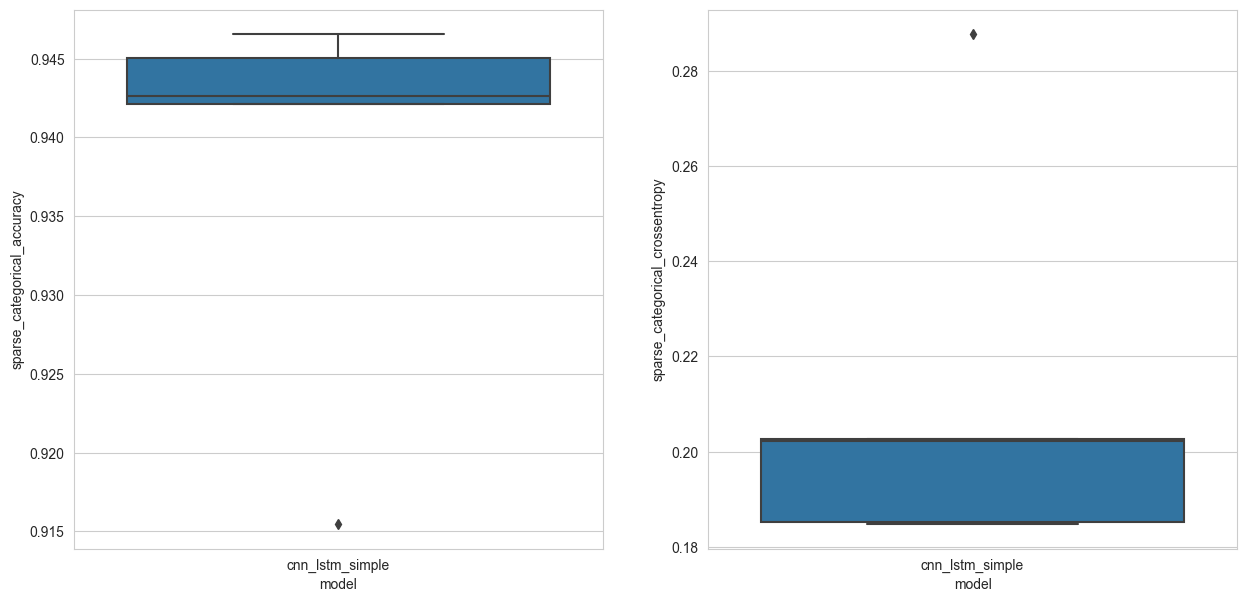

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=axes[0])
sns.boxplot(merged_data, x="model", y="sparse_categorical_crossentropy", ax=axes[1])
plt.show()

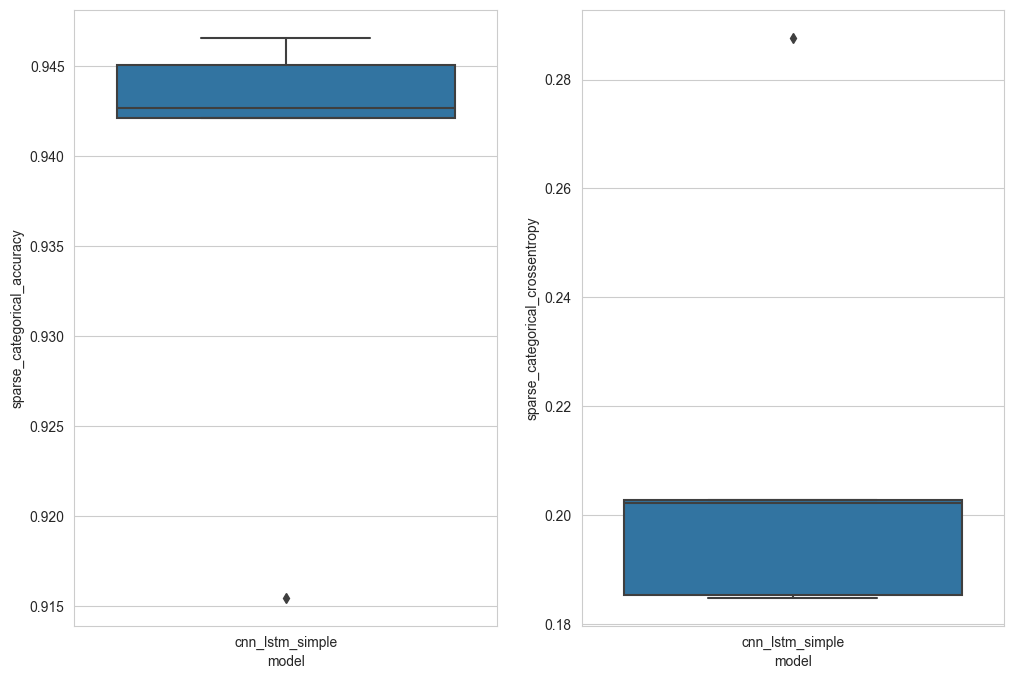

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
sns.boxplot(merged_data.loc[merged_data.model != "cnn_lstm_complex"], x="model", y="sparse_categorical_accuracy",
            ax=axes[0])
sns.boxplot(merged_data.loc[merged_data.model != "cnn_lstm_complex"], x="model", y="sparse_categorical_crossentropy",
            ax=axes[1])
plt.show()

## Confusion Matrix

### Load predicitons

In [5]:
TEST_DATA_PATH = "data/test"

results = []
for root, dirs, files in os.walk(TEST_DATA_PATH):
    if root != "data/test":
        label_name = root.split("\\")[-1]
        results.append(pd.DataFrame({
            "true_labels": [label_name] * len(files),
            "y_true": [class_names.index(label_name)] * len(files),
            "file": files
        }))
    else:
        class_names = dirs

true_labels = pd.concat(results).reset_index(drop=True)
true_labels

,true_labels,y_true,file
0,down,0,down0132a06d_nohash_0.wav
1,down,0,down0132a06d_nohash_4.wav
2,down,0,down0137b3f4_nohash_4.wav
3,down,0,down016e2c6d_nohash_1.wav
4,down,0,down016e2c6d_nohash_2.wav
...,...,...,...
13019,yes,11,yesfce96bac_nohash_0.wav
13020,yes,11,yesfd395b74_nohash_2.wav
13021,yes,11,yesfd395b74_nohash_4.wav
13022,yes,11,yesff21fb59_nohash_0.wav


In [6]:
# files = ["article_net", "cnn_lstm_complex", "cnn_lstm_simple", "stacked_bidirectional_lstm"]
files = ["cnn_lstm_simple"]
def get_predictions(files):
    results = []
    for file in files:
        for pred_file in os.listdir(file):
            if pred_file.startswith("predictions"):
                with open(os.path.join(file, pred_file), "rb") as handle:
                    prediction = pickle.load(handle)
                res = pd.DataFrame({
                    "model": [file] * prediction.shape[0],
                    "pred_file": [pred_file] * prediction.shape[0],
                    "predictions": np.argmax(prediction, axis=1)
                })
                results.append(res)
    return pd.concat(results)
predictions_df = get_predictions(files)
predictions_df

,model,pred_file,predictions
0,cnn_lstm_simple,predictions_0.pkl,0
1,cnn_lstm_simple,predictions_0.pkl,0
2,cnn_lstm_simple,predictions_0.pkl,0
3,cnn_lstm_simple,predictions_0.pkl,0
4,cnn_lstm_simple,predictions_0.pkl,0
...,...,...,...
13019,cnn_lstm_simple,predictions_4.pkl,11
13020,cnn_lstm_simple,predictions_4.pkl,9
13021,cnn_lstm_simple,predictions_4.pkl,9
13022,cnn_lstm_simple,predictions_4.pkl,11


In [7]:
def get_confussion_matrix(model_df):
    pred_files = [f"predictions_{i}.pkl" for i in range(5)]
    class_numbers = len(class_names)
    res_cm = np.zeros((class_numbers, class_numbers))
    for pred_file in pred_files:
        y_pred = model_df.loc[(model_df.pred_file == pred_file), 'predictions']
        cm = confusion_matrix(y_true=true_labels.y_true, y_pred=y_pred)
        res_cm += cm
    res_cm /= len(pred_files)
    return pd.DataFrame(res_cm, index=class_names, columns=class_names)

cm = get_confussion_matrix(predictions_df.loc[predictions_df.model == "cnn_lstm_simple"])
cm

,down,go,left,no,off,on,right,silence,stop,unknown,up,yes
down,403.6,9.4,0.2,12.8,0.4,0.4,0.0,0.0,1.6,42.8,0.4,0.4
go,10.2,386.0,0.6,12.8,1.4,0.6,0.2,0.2,3.6,55.4,2.4,0.6
left,0.2,0.2,424.6,2.2,1.0,0.0,4.0,0.0,0.8,29.6,1.0,7.4
no,5.4,10.6,1.0,422.6,0.8,0.0,0.0,0.0,0.6,31.4,1.0,1.6
off,0.4,0.6,1.4,0.0,405.4,10.8,0.6,0.6,1.6,30.4,19.2,0.0
on,1.0,0.6,0.0,0.2,10.6,404.2,0.0,0.8,0.4,52.6,2.2,0.4
right,0.0,0.0,6.4,0.0,1.2,0.4,416.4,0.0,0.0,48.2,0.2,0.2
silence,0.0,0.0,0.6,0.0,0.0,0.0,0.0,76.2,0.4,2.4,0.4,0.0
stop,2.2,1.4,0.2,0.6,1.8,0.8,0.0,0.0,431.8,31.0,6.0,0.2
unknown,31.2,29.6,14.4,25.0,13.6,30.4,21.8,0.0,16.6,8001.0,16.2,9.2


<Axes: xlabel='Predicted label', ylabel='True label'>

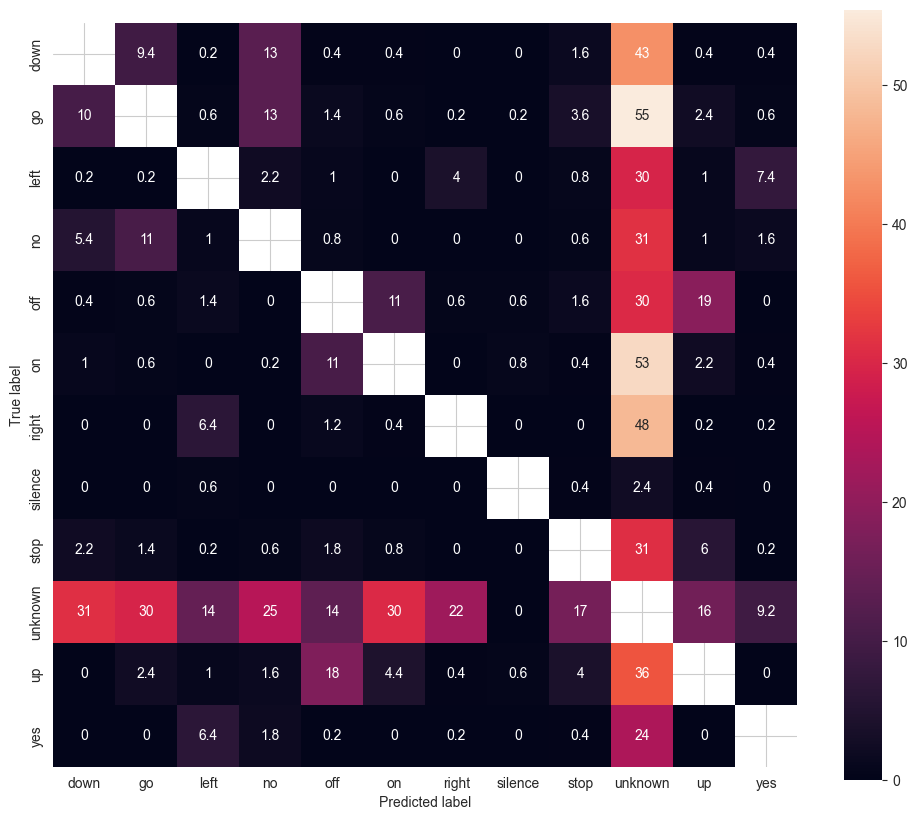

In [8]:
def draw_confusion_matrix(confusion_matrix, diag, ax=None, norm=None, cbar=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    if diag:
        mask = np.diag(v=np.ones(len(class_names))) == 1
        sns.heatmap(data=confusion_matrix, annot=True, mask=mask, ax=ax, norm=norm, cbar=cbar, square=True)
    else:
        sns.heatmap(data=confusion_matrix, annot=True, ax=ax, norm=norm, cbar=cbar, square=True)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    return ax

draw_confusion_matrix(cm, True)

<Axes: xlabel='Predicted label', ylabel='True label'>

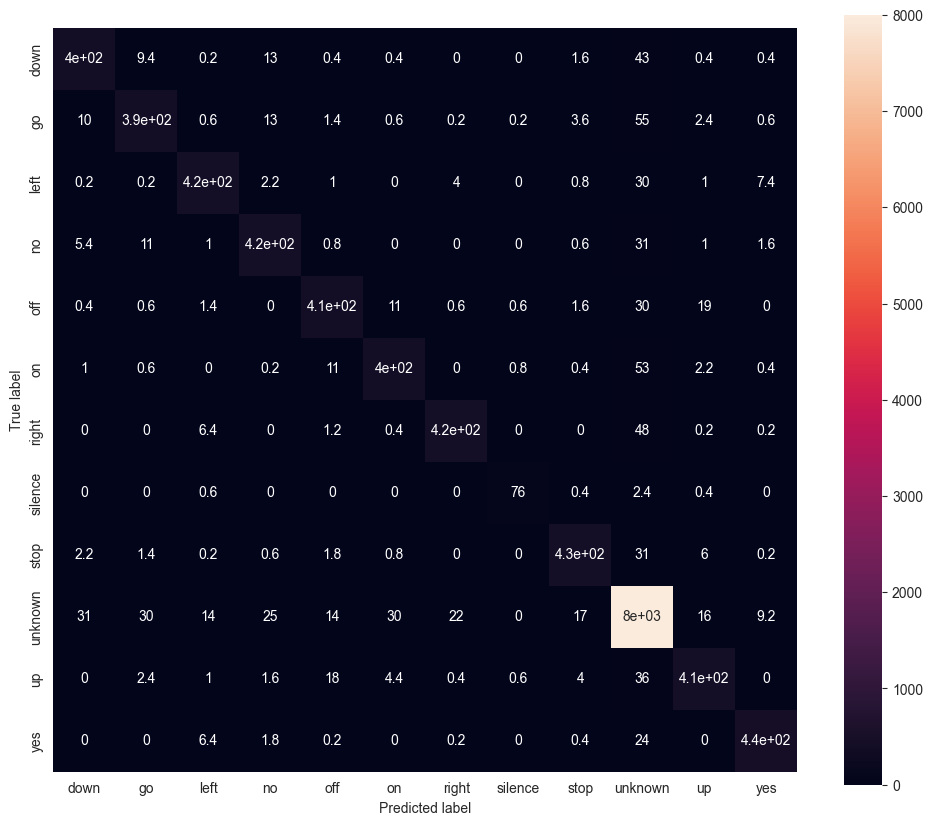

In [9]:
draw_confusion_matrix(cm, False)

## Learning curves

In [10]:
# files = ["article_net", "cnn_lstm_complex", "cnn_lstm_simple", "stacked_bidirectional_lstm"]
files = ["cnn_lstm_simple"]
def get_learning_curves(files):
    results = []
    for file in files:
        for hist_file in os.listdir(file):
            if hist_file.startswith("history"):
                with open(os.path.join(file, hist_file), "rb") as handle:
                    history = pickle.load(handle)
                res = pd.DataFrame(history)
                res["model"] = file
                res["history"] = hist_file
                res = res.reset_index(names="epoch")
                res["epoch"] += 1
                results.append(res)
    return pd.concat(results)

learning_curves = get_learning_curves(files)
learning_curves

,epoch,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy,lr,model,history
0,1,1.469400,0.624841,1.469400,1.328205,0.634884,1.328205,0.010000,cnn_lstm_simple,history_0.pkl
1,2,1.150972,0.663033,1.150972,0.958051,0.696914,0.958051,0.010000,cnn_lstm_simple,history_0.pkl
2,3,0.809909,0.741522,0.809909,0.703551,0.769538,0.703551,0.010000,cnn_lstm_simple,history_0.pkl
3,4,0.638341,0.800662,0.638341,0.627890,0.798250,0.627890,0.010000,cnn_lstm_simple,history_0.pkl
4,5,0.589835,0.814175,0.589835,0.494285,0.845233,0.494285,0.010000,cnn_lstm_simple,history_0.pkl
...,...,...,...,...,...,...,...,...,...,...
31,32,0.057230,0.985719,0.057230,0.160519,0.952403,0.160519,0.001250,cnn_lstm_simple,history_4.pkl
32,33,0.050995,0.988637,0.050995,0.162844,0.952710,0.162844,0.001250,cnn_lstm_simple,history_4.pkl
33,34,0.048400,0.989514,0.048400,0.164475,0.952710,0.164475,0.001250,cnn_lstm_simple,history_4.pkl
34,35,0.045150,0.990480,0.045150,0.162306,0.952403,0.162306,0.000625,cnn_lstm_simple,history_4.pkl


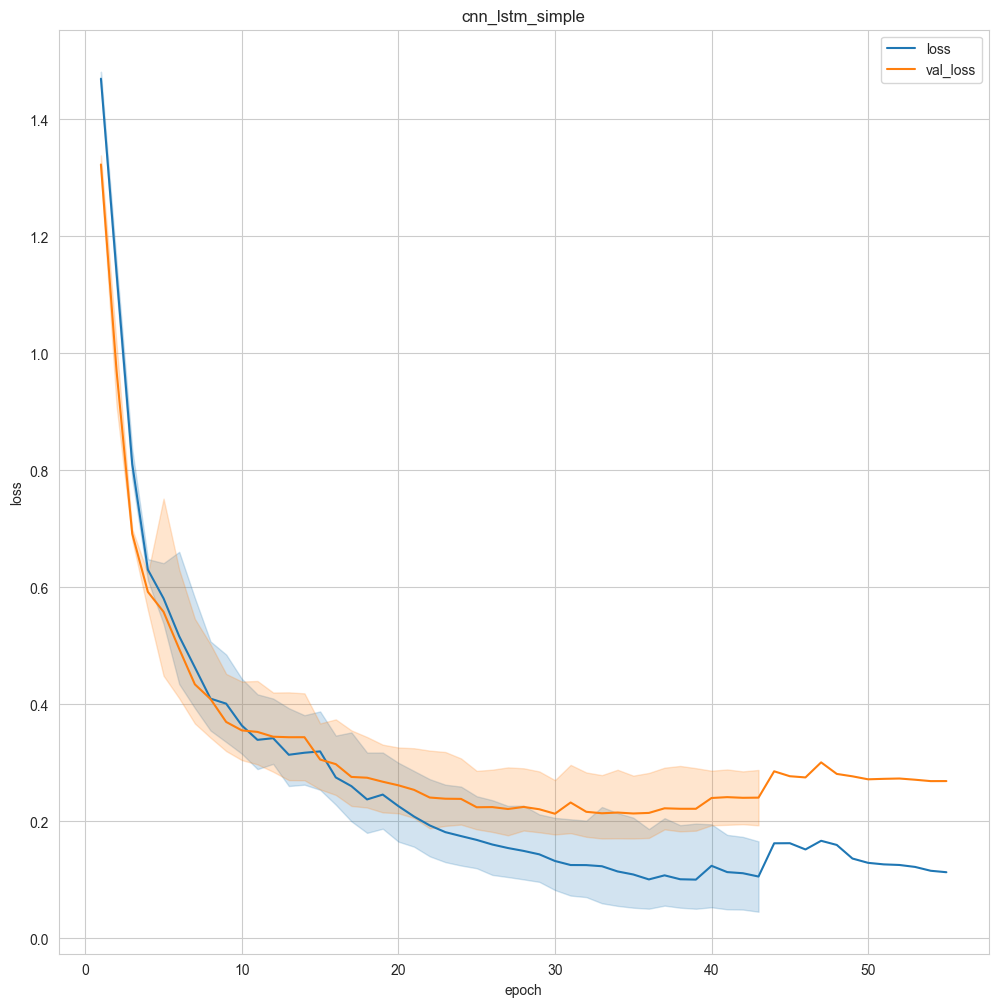

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    ax.set_title(file)
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax, label="loss")
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax, label="val_loss")
plt.show()

# CNN + LSTM

In [12]:
files = ["cnn_lstm_simple", "cnn_lstm_complex"]

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.202165,0.942107,0.202165,cnn_lstm_simple
1,1,0.202767,0.942644,0.202767,cnn_lstm_simple
2,2,0.184794,0.945025,0.184794,cnn_lstm_simple
3,3,0.287714,0.915464,0.287714,cnn_lstm_simple
4,4,0.185222,0.946560,0.185222,cnn_lstm_simple
5,0,0.544547,0.828547,0.544547,cnn_lstm_complex
6,1,0.674495,0.798526,0.674495,cnn_lstm_complex
7,2,0.479161,0.855037,0.479161,cnn_lstm_complex
8,3,0.335362,0.900108,0.335362,cnn_lstm_complex
9,4,0.557034,0.823787,0.557034,cnn_lstm_complex


<Axes: xlabel='model', ylabel='sparse_categorical_accuracy'>

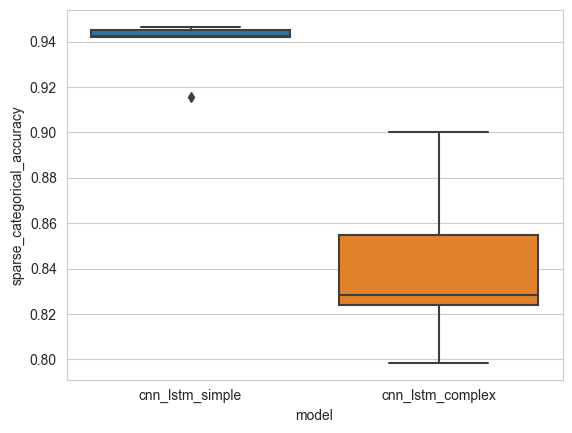

In [13]:
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy")

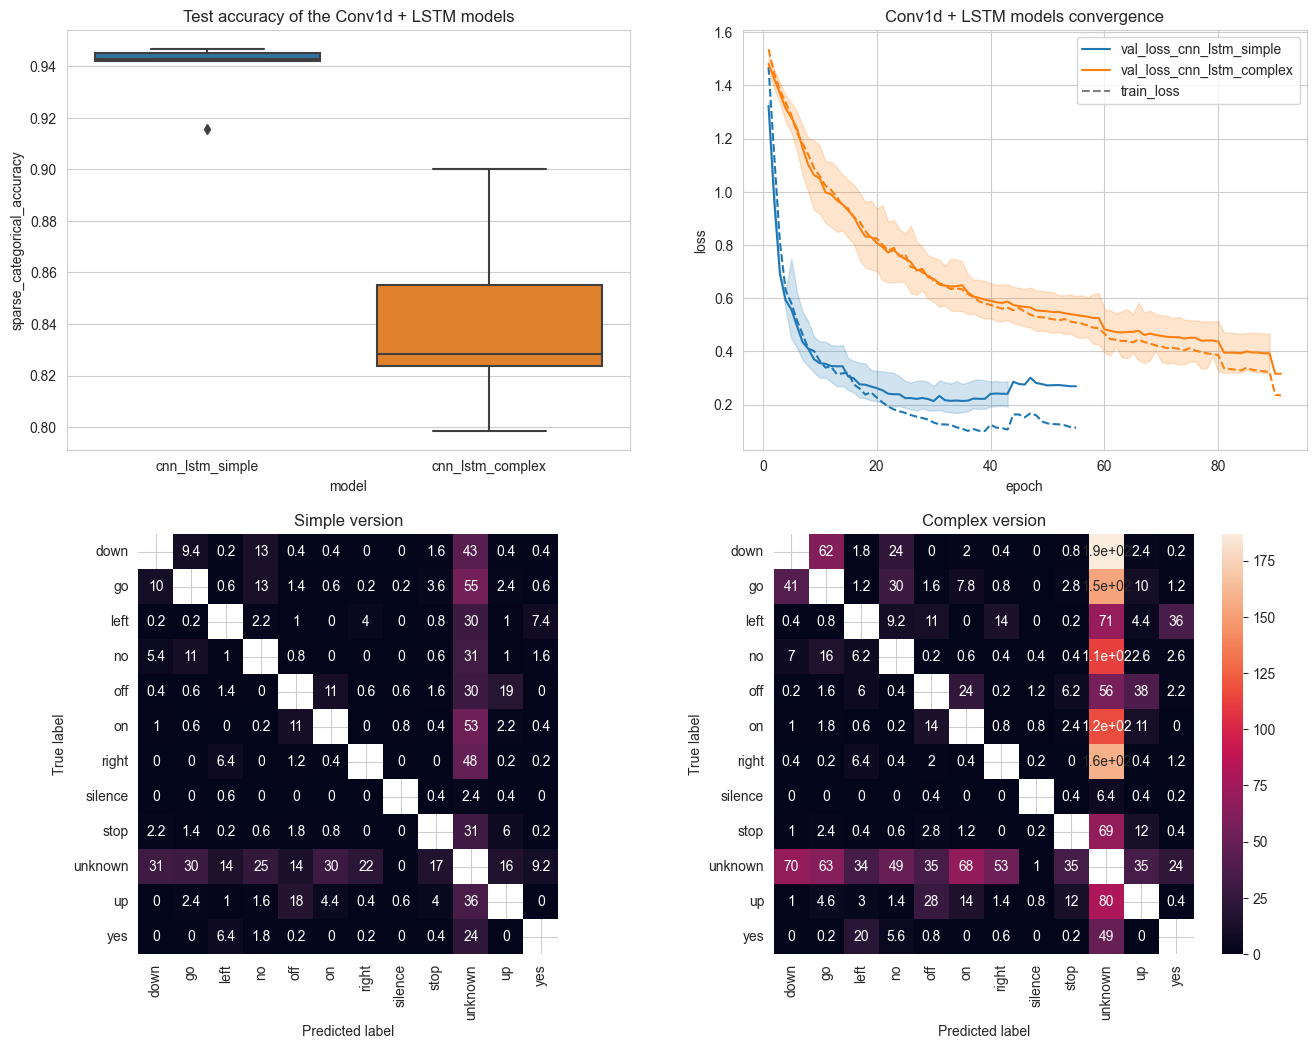

In [14]:

pyplot_colors = ['C' + str(i) for i in range(0, 10)]
learning_curves = get_learning_curves(files)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("Conv1d + LSTM models convergence")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy of the Conv1d + LSTM models")

predictions = get_predictions(files)
cm_simple = get_confussion_matrix(predictions[predictions.model == 'cnn_lstm_simple'])
cm_complex = get_confussion_matrix(predictions[predictions.model == 'cnn_lstm_complex'])
# normalize colors on both conf. mat.
for i in range(len(cm_simple)):
    cm_simple.iloc[i][i]=0
    cm_complex.iloc[i][i]=0
values = np.hstack([d.values.ravel() for d in [cm_simple, cm_complex]])
norm = mcolors.Normalize(values.min(), values.max())
# plot conf. mat.
draw_confusion_matrix(cm_simple, True, ax[1][0], norm, cbar=False)
draw_confusion_matrix(cm_complex, True, ax[1][1], norm)
ax[1][0].set_title("Simple version")
ax[1][1].set_title("Complex version")
plt.show()


# One - vs. bi- directional

In [15]:
files = ["stacked_bidirectional_lstm", "stacked_onedirectional_lstm"]

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.174891,0.949094,0.174891,stacked_bidirectional_lstm
1,1,0.181845,0.953087,0.181845,stacked_bidirectional_lstm
2,2,0.212424,0.944487,0.212424,stacked_bidirectional_lstm
3,3,0.169613,0.955390,0.169613,stacked_bidirectional_lstm
4,4,0.231978,0.942568,0.231978,stacked_bidirectional_lstm
5,0,0.198255,0.952933,0.198255,stacked_onedirectional_lstm
6,1,0.250526,0.946944,0.250526,stacked_onedirectional_lstm
7,2,0.183877,0.953547,0.183877,stacked_onedirectional_lstm
8,3,0.195825,0.953317,0.195825,stacked_onedirectional_lstm
9,4,0.211138,0.949862,0.211138,stacked_onedirectional_lstm


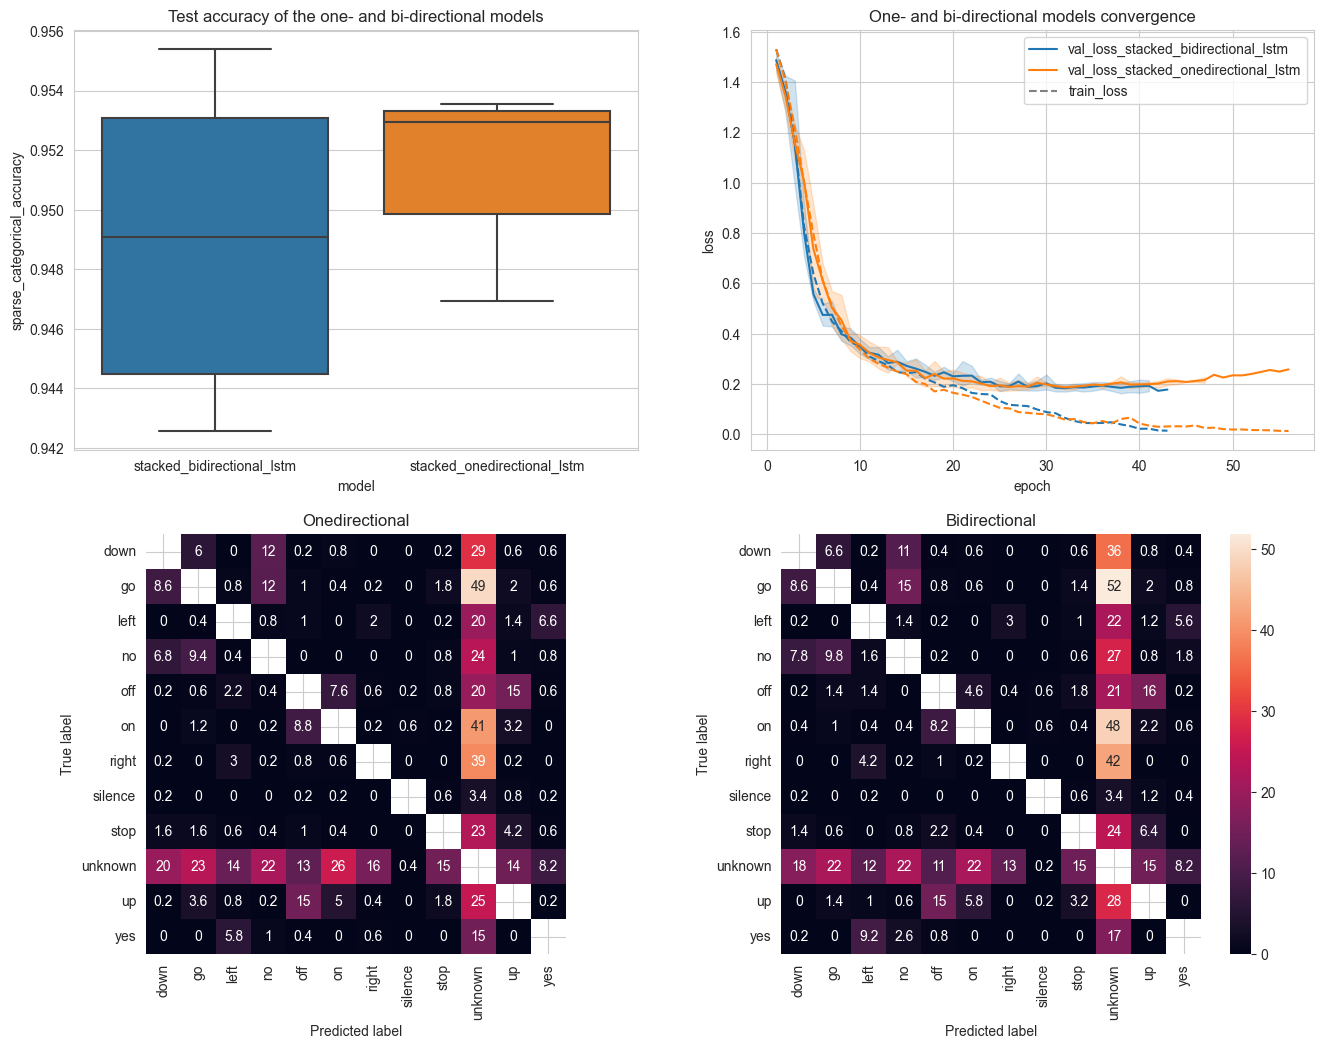

In [16]:
pyplot_colors = ['C' + str(i) for i in range(0, 10)]
learning_curves = get_learning_curves(files)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("One- and bi-directional models convergence")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy of the one- and bi-directional models")

predictions = get_predictions(files)
cm_2 = get_confussion_matrix(predictions[predictions.model == 'stacked_bidirectional_lstm'])
cm_1 = get_confussion_matrix(predictions[predictions.model == 'stacked_onedirectional_lstm'])
# normalize colors on both conf. mat.
for i in range(len(cm_1)):
    cm_1.iloc[i][i]=0
    cm_2.iloc[i][i]=0
values = np.hstack([d.values.ravel() for d in [cm_1, cm_2]])
norm = mcolors.Normalize(values.min(), values.max())
# plot conf. mat.
draw_confusion_matrix(cm_1, True, ax[1][0], norm, cbar=False)
draw_confusion_matrix(cm_2, True, ax[1][1], norm)
ax[1][0].set_title("Onedirectional")
ax[1][1].set_title("Bidirectional")
plt.show()


# Article Net - with and without weights

In [15]:
files = ['article_net', 'article_net_weighted']

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.145678,0.964988,0.145678,article_net
1,1,0.192862,0.964297,0.192862,article_net
2,2,0.193363,0.962684,0.193363,article_net
3,3,0.144507,0.965909,0.144507,article_net
4,4,0.189654,0.962147,0.189654,article_net
5,0,0.205750,0.953778,0.205750,article_net_weighted
6,1,0.189699,0.954469,0.189699,article_net_weighted
7,2,0.230322,0.950783,0.230322,article_net_weighted
8,3,0.243537,0.950630,0.243537,article_net_weighted
9,4,0.217451,0.935580,0.217451,article_net_weighted


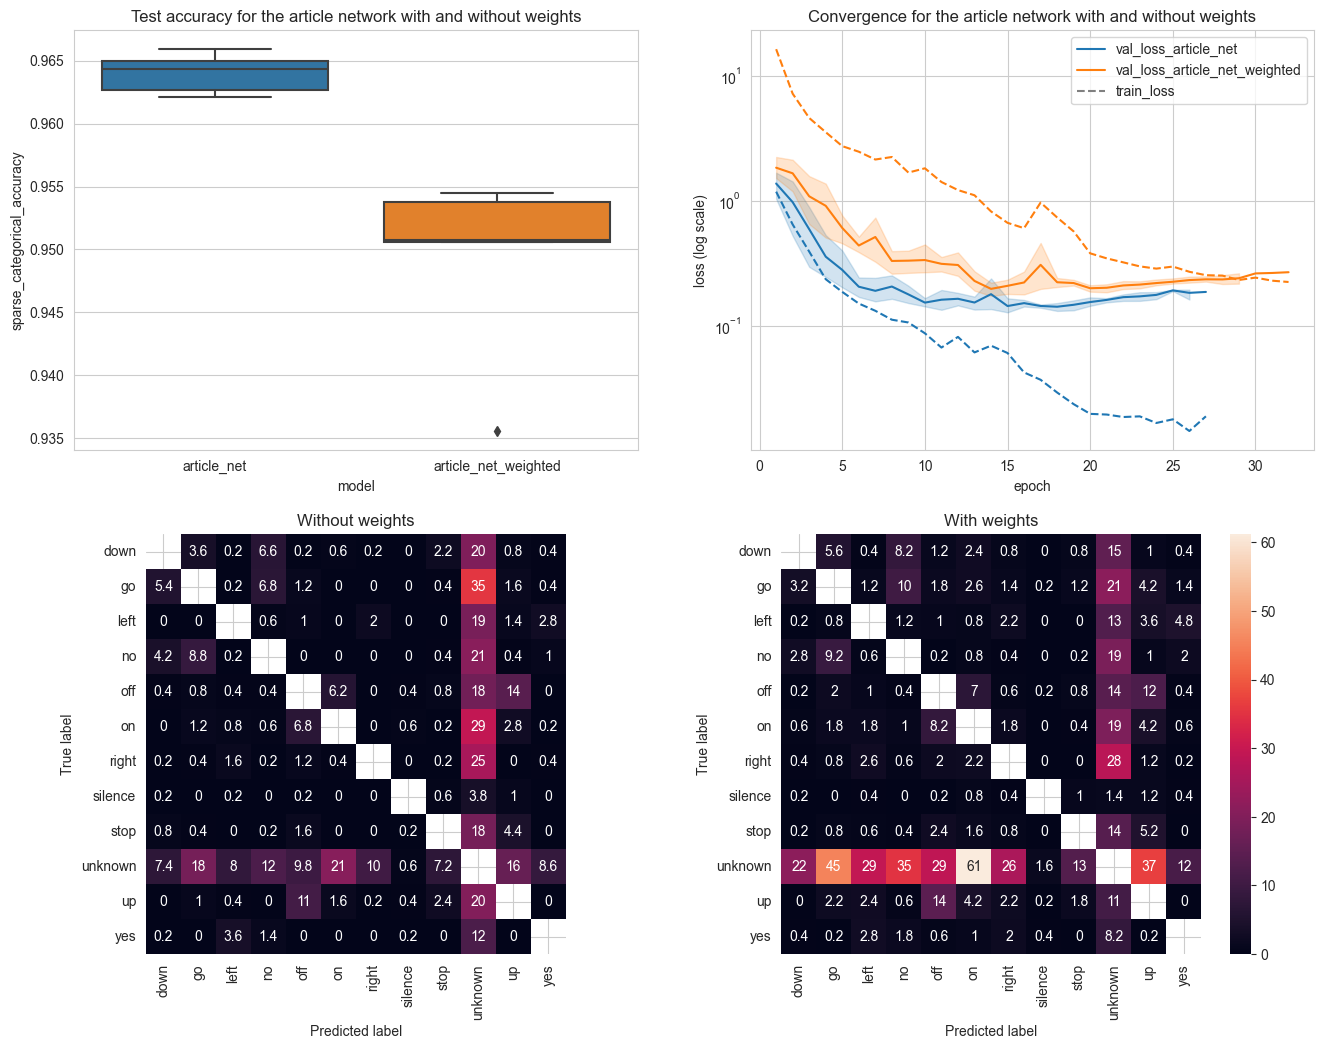

In [16]:
pyplot_colors = ['C' + str(i) for i in range(0, 10)]
learning_curves = get_learning_curves(files)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("Convergence for the article network with and without weights")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
ax[0][1].set_yscale('log')
ax[0][1].set_ylabel('loss (log scale)')
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy for the article network with and without weights")

predictions = get_predictions(files)
cm_1 = get_confussion_matrix(predictions[predictions.model == files[0]])
cm_2 = get_confussion_matrix(predictions[predictions.model == files[1]])
# normalize colors on both conf. mat.
for i in range(len(cm_1)):
    cm_1.iloc[i][i]=0
    cm_2.iloc[i][i]=0
values = np.hstack([d.values.ravel() for d in [cm_1, cm_2]])
norm = mcolors.Normalize(values.min(), values.max())
# plot conf. mat.
draw_confusion_matrix(cm_1, True, ax[1][0], norm=norm, cbar=False)
draw_confusion_matrix(cm_2, True, ax[1][1], norm=norm)
ax[1][0].set_title("Without weights")
ax[1][1].set_title("With weights")
plt.show()

# Article Net - dropout

In [27]:
files = ['article_net', 'article_net_0.1', 'article_net_0.3', 'article_net_0.5']

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.145678,0.964988,0.145678,article_net
1,1,0.192862,0.964297,0.192862,article_net
2,2,0.193363,0.962684,0.193363,article_net
3,3,0.144507,0.965909,0.144507,article_net
4,4,0.189654,0.962147,0.189654,article_net
5,0,0.194465,0.969518,0.194465,article_net_0.1
6,1,0.155209,0.964066,0.155209,article_net_0.1
7,2,0.140274,0.965679,0.140274,article_net_0.1
8,3,0.241239,0.965909,0.241239,article_net_0.1
9,4,0.167323,0.966754,0.167323,article_net_0.1


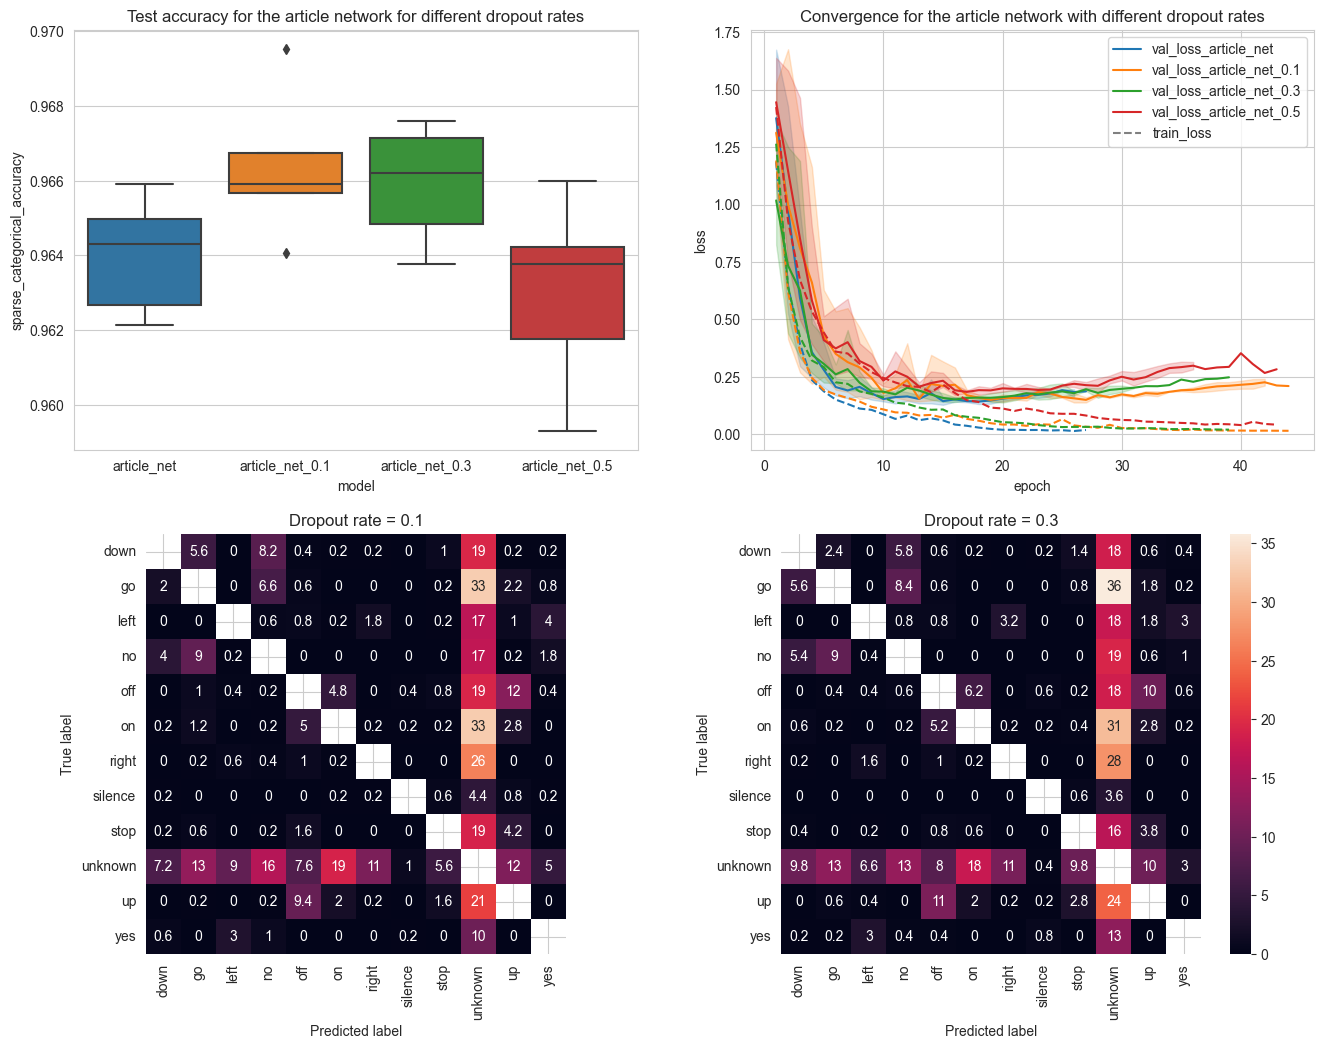

In [30]:
pyplot_colors = ['C' + str(i) for i in range(0, 10)]
learning_curves = get_learning_curves(files)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("Convergence for the article network with different dropout rates")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy for the article network for different dropout rates")

predictions = get_predictions(files)
cm_1 = get_confussion_matrix(predictions[predictions.model == files[1]])
cm_2 = get_confussion_matrix(predictions[predictions.model == files[2]])
# normalize colors on both conf. mat.
for i in range(len(cm_1)):
    cm_1.iloc[i][i]=0
    cm_2.iloc[i][i]=0
values = np.hstack([d.values.ravel() for d in [cm_1, cm_2]])
norm = mcolors.Normalize(values.min(), values.max())
# plot conf. mat.
draw_confusion_matrix(cm_1, True, ax[1][0], norm=norm, cbar=False)
draw_confusion_matrix(cm_2, True, ax[1][1], norm=norm)
ax[1][0].set_title("Dropout rate = 0.1")
ax[1][1].set_title("Dropout rate = 0.3")
plt.show()

# Article net - Augmentations

In [17]:
files = ['article_net', 'article_net_freq', 'article_net_time']

merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.145678,0.964988,0.145678,article_net
1,1,0.192862,0.964297,0.192862,article_net
2,2,0.193363,0.962684,0.193363,article_net
3,3,0.144507,0.965909,0.144507,article_net
4,4,0.189654,0.962147,0.189654,article_net
5,0,0.138397,0.969671,0.138397,article_net_freq
6,1,0.155362,0.969979,0.155362,article_net_freq
7,2,0.139853,0.967368,0.139853,article_net_freq
8,3,0.159299,0.969134,0.159299,article_net_freq
9,4,0.175304,0.955390,0.175304,article_net_freq


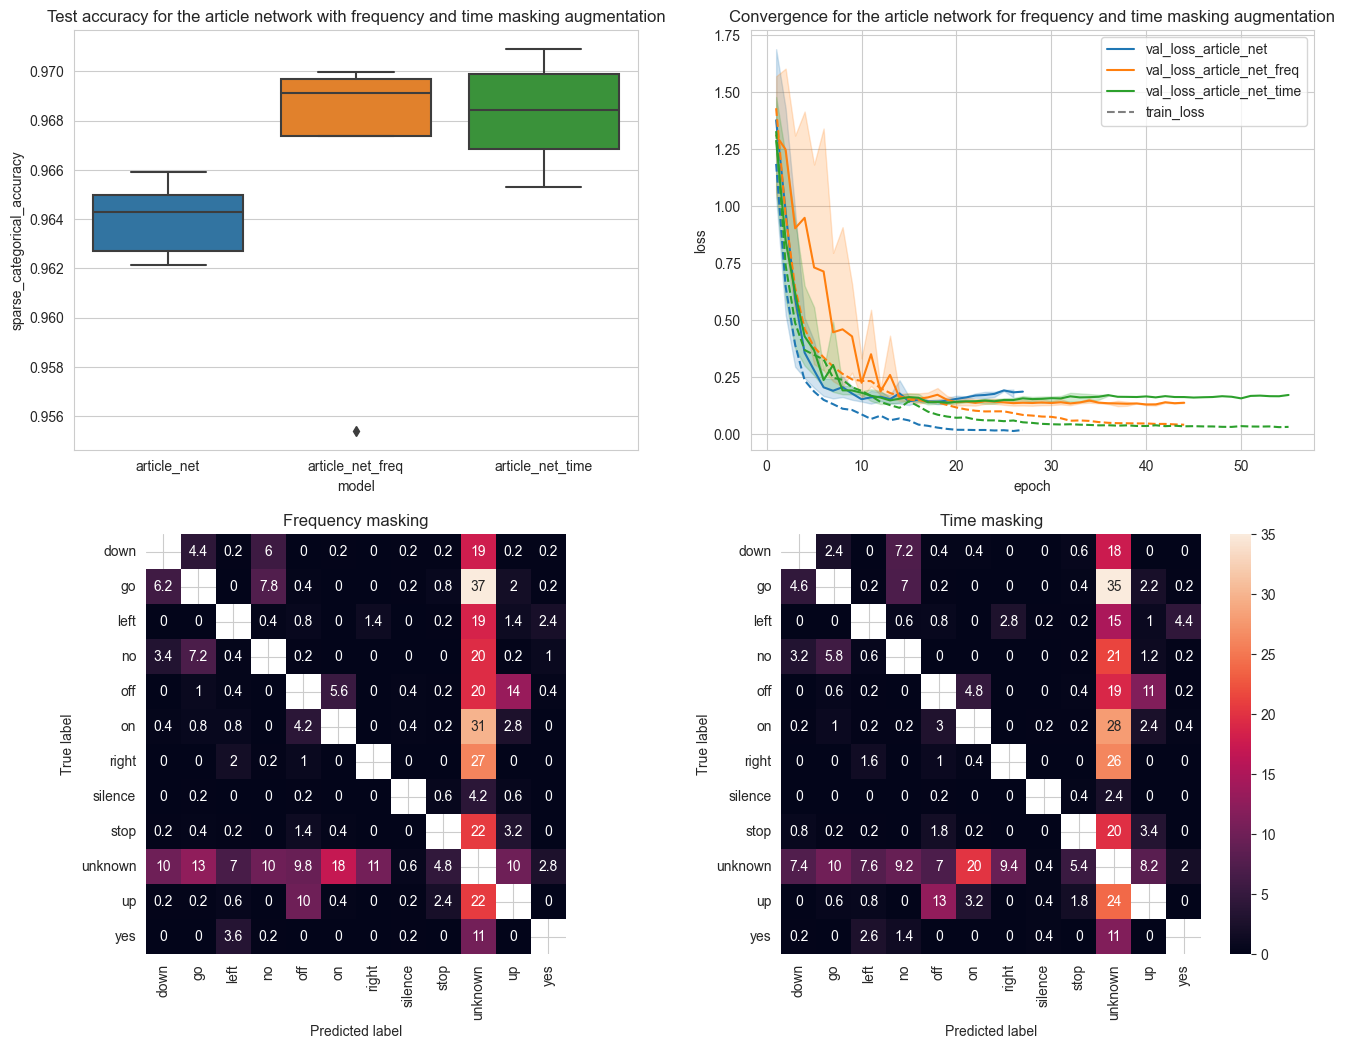

In [18]:
pyplot_colors = ['C' + str(i) for i in range(0, 10)]
learning_curves = get_learning_curves(files)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("Convergence for the article network for frequency and time masking augmentation")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy for the article network with frequency and time masking augmentation")

predictions = get_predictions(files)
cm_1 = get_confussion_matrix(predictions[predictions.model == files[1]])
cm_2 = get_confussion_matrix(predictions[predictions.model == files[2]])
# normalize colors on both conf. mat.
for i in range(len(cm_1)):
    cm_1.iloc[i][i]=0
    cm_2.iloc[i][i]=0
values = np.hstack([d.values.ravel() for d in [cm_1, cm_2]])
norm = mcolors.Normalize(values.min(), values.max())
# plot conf. mat.
draw_confusion_matrix(cm_1, True, ax[1][0], norm=norm, cbar=False)
draw_confusion_matrix(cm_2, True, ax[1][1])
ax[1][0].set_title("Frequency masking")
ax[1][1].set_title("Time masking")
plt.show()

# Plain LSTM - different layers

In [23]:
files = ['stacked_1_lstm', 'stacked_2_lstm', 'stacked_bidirectional_lstm']

merged_data = get_metrics(files)
learning_curves = get_learning_curves(files)
merged_data.model = merged_data.model.apply(lambda x: "stacked_3_lstm" if x == 'stacked_bidirectional_lstm' else x)
learning_curves.model = learning_curves.model.apply(lambda x: "stacked_3_lstm" if x == 'stacked_bidirectional_lstm' else x)
files = ['stacked_1_lstm', 'stacked_2_lstm', 'stacked_3_lstm']

merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.227594,0.929899,0.227594,stacked_1_lstm
1,1,0.215818,0.944103,0.215818,stacked_1_lstm
2,2,0.214621,0.937346,0.214621,stacked_1_lstm
3,3,0.245269,0.931434,0.245269,stacked_1_lstm
4,4,0.219817,0.935427,0.219817,stacked_1_lstm
5,0,0.234955,0.936195,0.234955,stacked_2_lstm
6,1,0.238033,0.933661,0.238033,stacked_2_lstm
7,2,0.271708,0.915694,0.271708,stacked_2_lstm
8,3,0.213273,0.940341,0.213273,stacked_2_lstm
9,4,0.235585,0.937116,0.235585,stacked_2_lstm


In [24]:
learning_curves

,epoch,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy,lr,model,history
0,1,1.353156,0.642785,1.353156,1.018118,0.688623,1.018118,0.010000,stacked_1_lstm,history_0.pkl
1,2,0.827324,0.743935,0.827324,0.761900,0.758944,0.761900,0.010000,stacked_1_lstm,history_0.pkl
2,3,0.655077,0.793906,0.655077,0.566739,0.820666,0.566739,0.010000,stacked_1_lstm,history_0.pkl
3,4,0.538669,0.829070,0.538669,0.515022,0.835713,0.515022,0.010000,stacked_1_lstm,history_0.pkl
4,5,0.505297,0.839227,0.505297,0.462359,0.846154,0.462359,0.010000,stacked_1_lstm,history_0.pkl
...,...,...,...,...,...,...,...,...,...,...
36,37,0.029633,0.992893,0.029633,0.212329,0.947797,0.212329,0.001250,stacked_3_lstm,history_4.pkl
37,38,0.032009,0.991686,0.032009,0.212960,0.946722,0.212960,0.001250,stacked_3_lstm,history_4.pkl
38,39,0.025313,0.993858,0.025313,0.214948,0.948104,0.214948,0.001250,stacked_3_lstm,history_4.pkl
39,40,0.022951,0.994735,0.022951,0.217340,0.946875,0.217340,0.000625,stacked_3_lstm,history_4.pkl


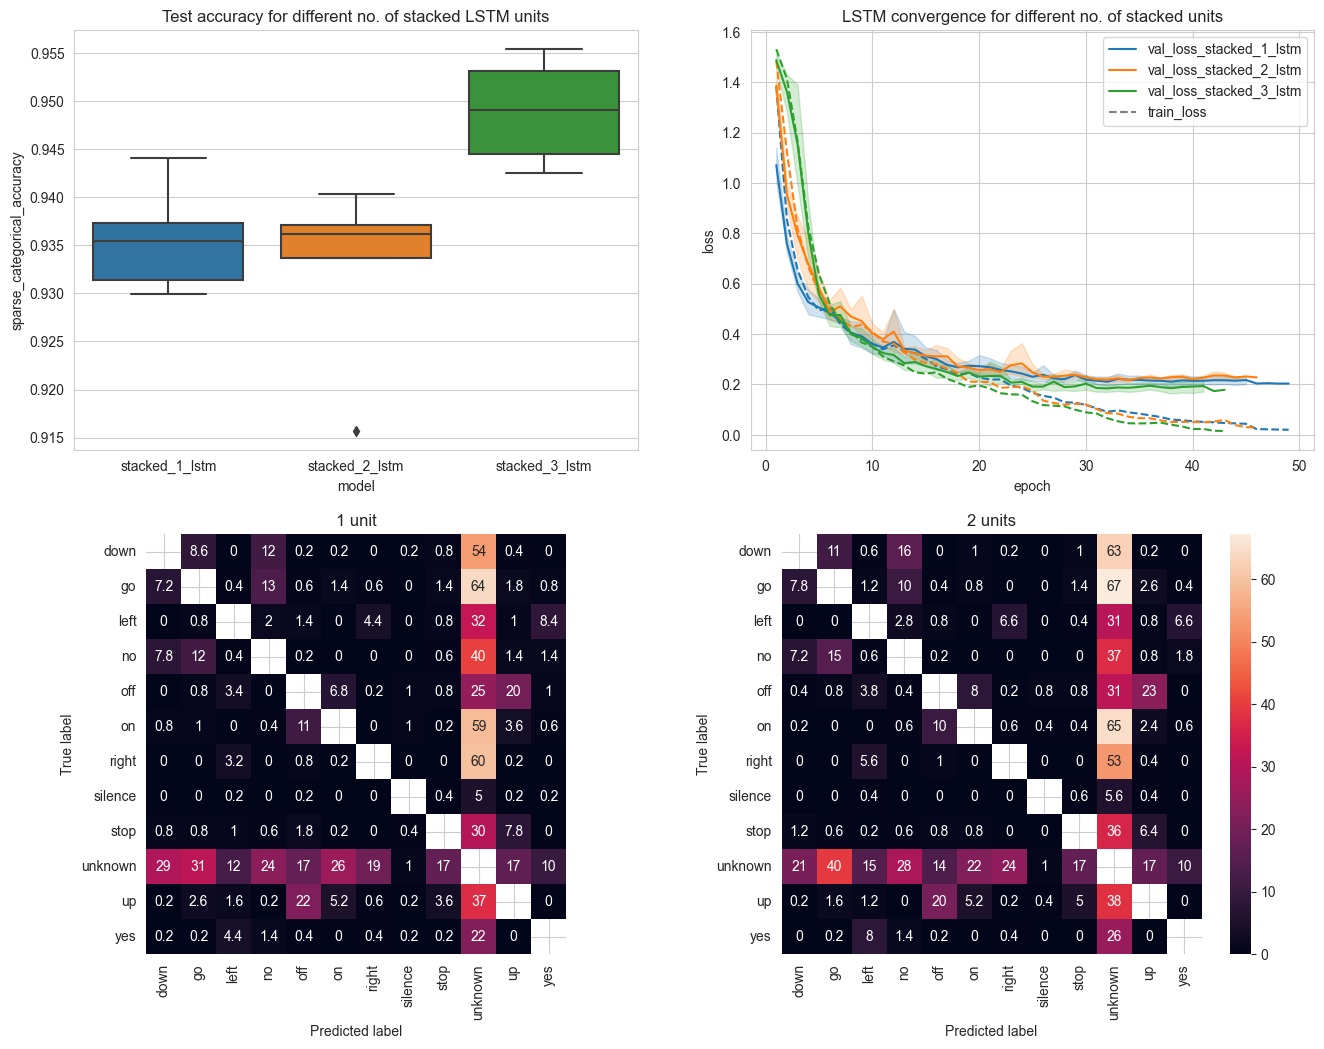

In [26]:
pyplot_colors = ['C' + str(i) for i in range(0, 10)]
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0][1].set_title("LSTM convergence for different no. of stacked units")
for i, file in enumerate(files):
    model_df = learning_curves.loc[learning_curves.model == file]
    # row, col = i // 2, i % 2
    # ax = axes[row][col]
    color = pyplot_colors[i]
    leg = "auto" if i != 0 else False
    sns.lineplot(model_df, x="epoch", y="loss", ax=ax[0][1], label=None, ls='--', errorbar=None, color=color)
    sns.lineplot(model_df, x="epoch", y="val_loss", ax=ax[0][1], label="val_loss_"+file, color=color)

train_legend_line = Line2D([0], [0], label='train_loss', color='grey', ls='--')
handles, labels = ax[0][1].get_legend_handles_labels()
handles.extend([train_legend_line])
ax[0][1].legend(handles=handles)
sns.boxplot(merged_data, x="model", y="sparse_categorical_accuracy", ax=ax[0][0])
ax[0][0].set_title("Test accuracy for different no. of stacked LSTM units")
files = ['stacked_1_lstm', 'stacked_2_lstm', 'stacked_bidirectional_lstm']
predictions = get_predictions(files)
cm_1 = get_confussion_matrix(predictions[predictions.model == 'stacked_1_lstm'])
cm_2 = get_confussion_matrix(predictions[predictions.model == 'stacked_2_lstm'])
# normalize colors on both conf. mat.
for i in range(len(cm_1)):
    cm_1.iloc[i][i]=0
    cm_2.iloc[i][i]=0
values = np.hstack([d.values.ravel() for d in [cm_1, cm_2]])
norm = mcolors.Normalize(values.min(), values.max())
# plot conf. mat.
draw_confusion_matrix(cm_1, True, ax[1][0], norm=norm, cbar=False)
draw_confusion_matrix(cm_2, True, ax[1][1])
ax[1][0].set_title("1 unit")
ax[1][1].set_title("2 units")
plt.show()


# Results summary

In [49]:
files = ['article_net', 'article_net_0.1', 'article_net_0.3', 'article_net_0.5', 'article_net_freq', 'article_net_time', 'article_net_weighted', 'stacked_1_lstm', 'stacked_2_lstm', 'stacked_onedirectional_lstm', 'stacked_bidirectional_lstm',  'cnn_lstm_simple', 'cnn_lstm_complex',]
merged_data = get_metrics(files)
merged_data

,seed,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,model
0,0,0.145678,0.964988,0.145678,article_net
1,1,0.192862,0.964297,0.192862,article_net
2,2,0.193363,0.962684,0.193363,article_net
3,3,0.144507,0.965909,0.144507,article_net
4,4,0.189654,0.962147,0.189654,article_net
...,...,...,...,...,...
60,0,0.544547,0.828547,0.544547,cnn_lstm_complex
61,1,0.674495,0.798526,0.674495,cnn_lstm_complex
62,2,0.479161,0.855037,0.479161,cnn_lstm_complex
63,3,0.335362,0.900108,0.335362,cnn_lstm_complex


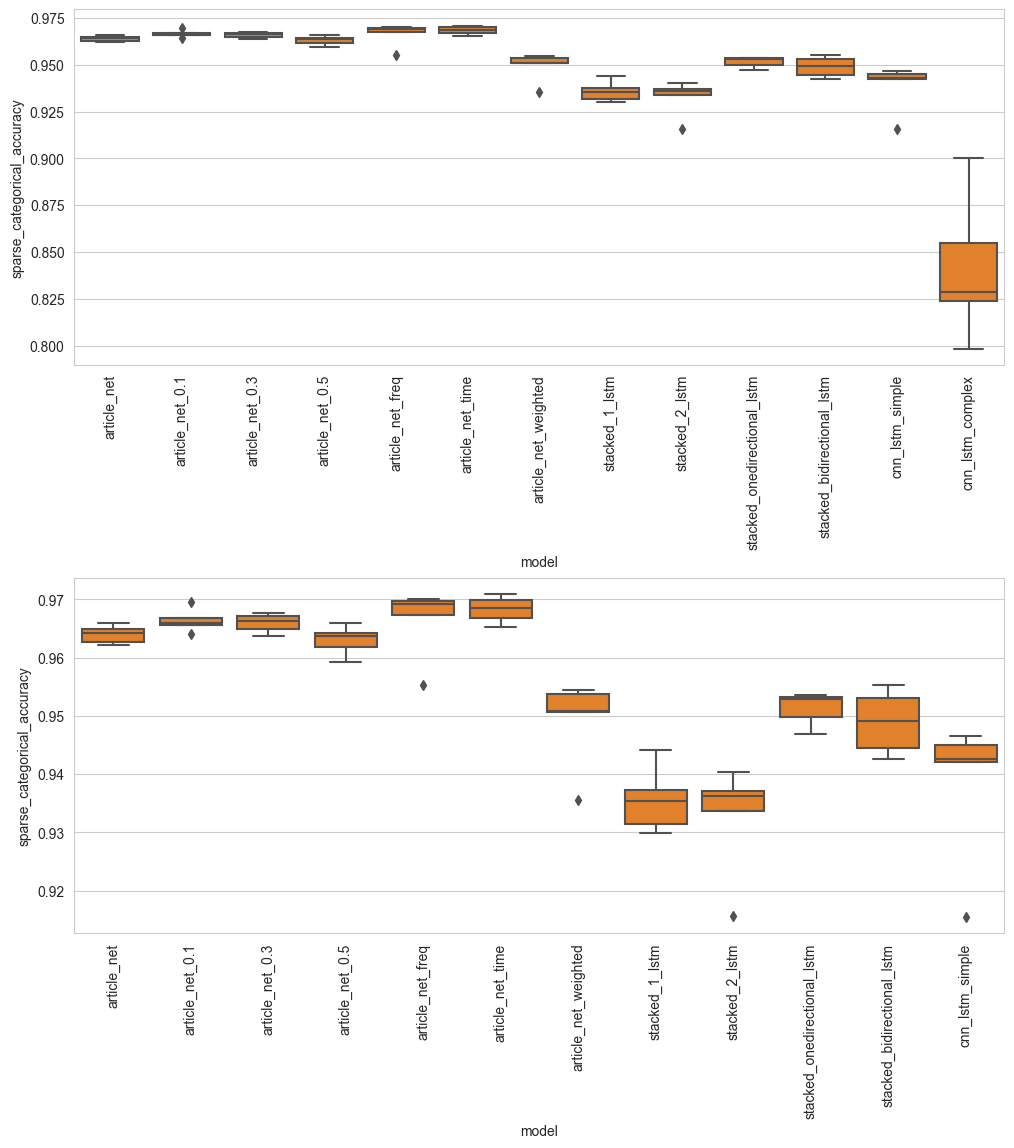

In [61]:
fig, ax = plt.subplots(2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.6)
color = pyplot_colors[1]
sns.boxplot(merged_data, x='model', y='sparse_categorical_accuracy', ax=ax[0], color=color)
ax[0].set_xticks(ax[0].get_xticks(), ax[0].get_xticklabels(), rotation='vertical')


sns.boxplot(merged_data[merged_data['model'] != 'cnn_lstm_complex'], x='model', y='sparse_categorical_accuracy', ax=ax[1], color=color)
ax[1].set_xticks(ax[1].get_xticks(), ax[1].get_xticklabels(), rotation='vertical')
plt.show()